# i. Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## To Display all columns
pd.set_option('display.max_columns', 500)
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import LinearSVR as LSVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score, mean_absolute_error
from time import time

# ii. load the data

In [2]:
boston_listings = pd.read_csv('boston-airbnb-open-data/listings.csv')

# iii. Remove data removed in Understanding.ipynb

In [3]:
boston_listings.city.value_counts()/boston_listings.shape[0]*100

Boston                       94.309623
Roxbury Crossing              0.669456
Somerville                    0.529986
Brookline                     0.502092
Jamaica Plain                 0.502092
Cambridge                     0.446304
Charlestown                   0.418410
Brighton                      0.418410
Dorchester                    0.418410
Allston                       0.334728
Roslindale                    0.167364
West Roxbury                  0.139470
ROXBURY CROSSING              0.111576
East Boston                   0.083682
Mattapan                      0.083682
South Boston                  0.055788
Jamaica Plain                 0.055788
ALLSTON                       0.055788
Hyde Park                     0.055788
Jamaica Plain, Boston         0.055788
Boston, Massachusetts, US     0.055788
Mission Hill, Boston          0.027894
Jamaica Plain, MA             0.027894
Brighton                      0.027894
Jamaica Plain (Boston)        0.027894
east Boston              

In [4]:
boston_listings.state.value_counts()/boston_listings.shape[0]*100

MA    100.0
Name: state, dtype: float64

In [5]:
boston_listings.drop(columns = ['license','square_feet','requires_license','has_availability',
                                 'experiences_offered','city','state',
                                 'jurisdiction_names','market','smart_location',
                                'country_code','country','calendar_last_scraped',
                                'scrape_id','last_scraped','neighbourhood_group_cleansed'],inplace=True)

In [6]:
boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 79 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986 non-null object
medium_url                          2986 non-null object
picture_url                         3585 non-null object
xl_picture_url                      298

 # 3. Prepare Data 

For now we will drop the descriptive attributes and leave only the categorical and numerical features.
Will also drop urls for images and listing.

In [7]:
boston_listings_n = boston_listings.drop(columns = ['listing_url','name', 'summary','space','description',
                                                     'neighborhood_overview','notes','transit','thumbnail_url',
                                                     'medium_url', 'picture_url', 'xl_picture_url', 'host_url',
                                                     'host_about','host_thumbnail_url','host_picture_url',
                                                     'host_name','host_id','id','host_neighbourhood','access',
                                                     'interaction','house_rules'])

In [8]:
boston_listings_n.head()

,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015-04-15,"Boston, Massachusetts, United States",NaN,NaN,NaN,f,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,02131,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,f,f,1,NaN
1,2012-06-07,"Boston, Massachusetts, United States",within an hour,100%,100%,f,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,02131,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,t,moderate,f,f,1,1.30
2,2009-05-11,"Boston, Massachusetts, United States",within a few hours,100%,88%,t,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,02131,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,$395.00,"$1,350.00",NaN,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,moderate,t,f,1,0.47
3,2013-04-21,"Boston, Massachusetts, United States",within a few hours,100%,50%,f,1,1,"['email', 'phone', 'reviews']",t,f,"Boston, MA, United States",NaN,Roslindale,NaN,42.281106,-71.121021,f,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,NaN,NaN,$100.00,$50.00,2,$25.00,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,1,1.00
4,2014-05-11,"Boston, Massachusetts, United States",within an hour,100%,100%,t,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Durnell Avenue, Boston, MA 02131, United States",Roslindale,Roslindale,02131,42.284512,-71.136258,t,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00,NaN,NaN,NaN,$15.00,1,$0.00,2,31,2 weeks ago,13,34,59,334,29,2015-08-18,2016-09-01,99.0,10.0,10.0,10.0,10.0,9.0,10.0,f,flexible,f,f,1,2.25


In [9]:
boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 79 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986 non-null object
medium_url                          2986 non-null object
picture_url                         3585 non-null object
xl_picture_url                      298

In [10]:
boston_listings_n.host_location.notna().sum()/boston_listings_n.shape[0]

0.996931659693166

In [11]:
boston_listings_n.host_location.value_counts()/boston_listings_n.shape[0]*100

Boston, Massachusetts, United States               67.531381
US                                                 14.532775
New York, New York, United States                   3.152022
Montreal, Quebec, Canada                            1.645746
Middlesex County, Massachusetts, United States      1.394700
Cambridge, Massachusetts, United States             1.171548
Massachusetts, United States                        0.781032
Spokane, Washington, United States                  0.697350
Brookline, Massachusetts, United States             0.529986
Somerville, Massachusetts, United States            0.474198
Medford, Massachusetts, United States               0.278940
Milton, Massachusetts, United States                0.278940
San Francisco, California, United States            0.195258
Cohasset, Massachusetts, United States              0.167364
Santa Monica, California, United States             0.167364
Newton, Massachusetts, United States                0.167364
United States           

In [12]:
boston_listings_n.drop(columns= ['host_location'],inplace=True)

In [13]:
print(boston_listings_n.street.notna().sum()/boston_listings_n.shape[0])
print(boston_listings_n.street.value_counts()/boston_listings_n.shape[0]*100)
boston_listings_n.drop(columns= ['street'],inplace=True)

1.0
Boylston Street, Boston, MA 02215, United States            1.785216
Beacon Street, Boston, MA 02116, United States              1.394700
Garrison Street, Boston, MA 02116, United States            1.227336
Brookline Avenue, Boston, MA 02215, United States           1.143654
Columbus Avenue, Boston, MA 02116, United States            0.864714
Massachusetts Avenue, Boston, MA 02118, United States       0.836820
Commonwealth Avenue, Boston, MA 02134, United States        0.836820
Boston, MA, United States                                   0.836820
Seaport Boulevard, Boston, MA 02210, United States          0.781032
Commonwealth Avenue, Boston, MA 02135, United States        0.781032
Newbury Street, Boston, MA 02116, United States             0.725244
Charles Street, Boston, MA 02114, United States             0.669456
Washington Street, Boston, MA 02116, United States          0.669456
Emerson Place, Boston, MA 02114, United States              0.613668
Harrison Avenue, Boston, MA 02

In [14]:
print(boston_listings_n.neighbourhood_cleansed.notna().sum()/boston_listings_n.shape[0])
print(boston_listings_n.neighbourhood_cleansed.value_counts()/boston_listings_n.shape[0]*100)
print(boston_listings_n.neighbourhood.notna().sum()/boston_listings_n.shape[0])
print(boston_listings_n.neighbourhood.value_counts()/boston_listings_n.shape[0]*100)

1.0
Jamaica Plain              9.567643
South End                  9.093445
Back Bay                   8.423989
Fenway                     8.089261
Dorchester                 7.503487
Allston                    7.252441
Beacon Hill                5.411437
Brighton                   5.160391
South Boston               4.853556
Downtown                   4.797768
East Boston                4.184100
Roxbury                    4.016736
North End                  3.988842
Mission Hill               3.458856
Charlestown                3.096234
South Boston Waterfront    2.315202
Chinatown                  1.980474
Roslindale                 1.562064
West End                   1.366806
West Roxbury               1.283124
Hyde Park                  0.864714
Bay Village                0.669456
Mattapan                   0.669456
Longwood Medical Area      0.251046
Leather District           0.139470
Name: neighbourhood_cleansed, dtype: float64
0.8485355648535565
Allston-Brighton      10.153417


neighbourhood_cleansed Has no NaNs so will be left

In [15]:
boston_listings_n.drop(columns= ['neighbourhood'],inplace=True)

In [16]:
tf_cols = ['host_is_superhost','host_has_profile_pic', 'instant_bookable','require_guest_profile_picture',
           'host_identity_verified','is_location_exact','require_guest_phone_verification']

In [17]:
for col in tf_cols:
    print(boston_listings_n[col].isna().sum())
    print(boston_listings_n[col].notna().sum()/boston_listings_n.shape[0])
    print(boston_listings_n[col].value_counts()/boston_listings_n.shape[0]*100)

0
1.0
f    88.647141
t    11.352859
Name: host_is_superhost, dtype: float64
0
1.0
t    99.776848
f     0.223152
Name: host_has_profile_pic, dtype: float64
0
1.0
f    83.430962
t    16.569038
Name: instant_bookable, dtype: float64
0
1.0
f    98.131102
t     1.868898
Name: require_guest_profile_picture, dtype: float64
0
1.0
t    72.608089
f    27.391911
Name: host_identity_verified, dtype: float64
0
1.0
t    85.913529
f    14.086471
Name: is_location_exact, dtype: float64
0
1.0
f    93.389121
t     6.610879
Name: require_guest_phone_verification, dtype: float64


Dropped two columns with more than 98% for one value

In [18]:
boston_listings_n.drop(columns= ['require_guest_profile_picture','host_has_profile_pic'],inplace=True)

In [19]:
tf_cols = ['host_is_superhost', 'instant_bookable',
           'host_identity_verified','is_location_exact','require_guest_phone_verification']
for col in tf_cols:
    boston_listings_n[col] = boston_listings_n[col].map({'t':True,'f':False})
    print(boston_listings_n[col].isna().sum())
    print(boston_listings_n[col].notna().sum()/boston_listings_n.shape[0])
    print(boston_listings_n[col].value_counts()/boston_listings_n.shape[0]*100)

0
1.0
False    88.647141
True     11.352859
Name: host_is_superhost, dtype: float64
0
1.0
False    83.430962
True     16.569038
Name: instant_bookable, dtype: float64
0
1.0
True     72.608089
False    27.391911
Name: host_identity_verified, dtype: float64
0
1.0
True     85.913529
False    14.086471
Name: is_location_exact, dtype: float64
0
1.0
False    93.389121
True      6.610879
Name: require_guest_phone_verification, dtype: float64


In [20]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015-04-15,NaN,NaN,NaN,False,1,1,"['email', 'phone', 'facebook', 'reviews']",False,Roslindale,02131,42.282619,-71.133068,True,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,moderate,False,1,NaN
1,2012-06-07,within an hour,100%,100%,False,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",True,Roslindale,02131,42.286241,-71.134374,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,1,1.30
2,2009-05-11,within a few hours,100%,88%,True,1,1,"['email', 'phone', 'reviews', 'jumio']",True,Roslindale,02131,42.292438,-71.135765,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,$395.00,"$1,350.00",NaN,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,False,1,0.47
3,2013-04-21,within a few hours,100%,50%,False,1,1,"['email', 'phone', 'reviews']",False,Roslindale,NaN,42.281106,-71.121021,False,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,NaN,NaN,$100.00,$50.00,2,$25.00,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,moderate,False,1,1.00
4,2014-05-11,within an hour,100%,100%,True,1,1,"['email', 'phone', 'reviews', 'kba']",True,Roslindale,02131,42.284512,-71.136258,True,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",$79.00,NaN,NaN,NaN,$15.00,1,$0.00,2,31,2 weeks ago,13,34,59,334,29,2015-08-18,2016-09-01,99.0,10.0,10.0,10.0,10.0,9.0,10.0,False,flexible,False,1,2.25


In [21]:
print(boston_listings_n.host_verifications.notna().sum()/boston_listings_n.shape[0])
print(boston_listings_n.amenities.notna().sum()/boston_listings_n.shape[0])

1.0
1.0


In [22]:
amenities_d = {}
for row in range(boston_listings_n.shape[0]):
    for amenity_u in boston_listings_n.iloc[row]['amenities'][1:-1].split(','):
        amenity = ''.join(e for e in amenity_u if e.isalnum())
        if amenity == '':
            continue
        if amenity not in amenities_d:
            amenities_d[amenity] =1 
            continue
        amenities_d[amenity] += 1

In [23]:
amenities_d

{'TV': 2607,
 'WirelessInternet': 3421,
 'Kitchen': 3284,
 'FreeParkingonPremises': 831,
 'Petsliveonthisproperty': 429,
 'Dogs': 229,
 'Heating': 3384,
 'FamilyKidFriendly': 1888,
 'Washer': 2475,
 'Dryer': 2476,
 'SmokeDetector': 2911,
 'FireExtinguisher': 1582,
 'Essentials': 2994,
 'Shampoo': 2421,
 'LaptopFriendlyWorkspace': 1834,
 'Internet': 2577,
 'AirConditioning': 2821,
 'PetsAllowed': 486,
 'CarbonMonoxideDetector': 2442,
 'LockonBedroomDoor': 474,
 'Hangers': 1985,
 'HairDryer': 1811,
 'Iron': 1828,
 'CableTV': 1770,
 'FirstAidKit': 1063,
 'SafetyCard': 458,
 'translationmissingenhostingamenity49': 444,
 'translationmissingenhostingamenity50': 581,
 'Gym': 479,
 'Breakfast': 316,
 'IndoorFireplace': 393,
 'Cats': 181,
 '24HourCheckin': 1247,
 'HotTub': 167,
 'BuzzerWirelessIntercom': 839,
 'Otherpets': 16,
 'WasherDryer': 2,
 'SmokingAllowed': 95,
 'SuitableforEvents': 138,
 'WheelchairAccessible': 148,
 'ElevatorinBuilding': 868,
 'Pool': 160,
 'Doorman': 268,
 'PaidParkin

In [24]:
host_verifications_d = {}
for row in range(boston_listings_n.shape[0]):
    for ver_u in boston_listings_n.iloc[row]['host_verifications'][1:-1].split(','):
        ver = ''.join(e for e in ver_u if e.isalnum())
        if ver == '':
            continue
        if ver not in host_verifications_d:
            host_verifications_d[ver] =1 
            continue
        host_verifications_d[ver] += 1

In [25]:
host_verifications_d 

{'email': 3492,
 'phone': 3575,
 'facebook': 627,
 'reviews': 3319,
 'linkedin': 84,
 'amex': 84,
 'jumio': 1438,
 'kba': 1282,
 'manualonline': 78,
 'manualoffline': 159,
 'google': 109,
 'sentid': 3,
 'weibo': 11}

In [26]:
verifications = list(host_verifications_d.keys())
amenties = list(amenities_d.keys())

In [27]:
for ver in verifications:
    boston_listings_n[ver] = [False]* boston_listings_n.shape[0]
for amenty in amenties:
    boston_listings_n[amenty] = [False]* boston_listings_n.shape[0]  

In [28]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet
0,2015-04-15,NaN,NaN,NaN,False,1,1,"['email', 'phone', 'facebook', 'reviews']",False,Roslindale,02131,42.282619,-71.133068,True,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,moderate,False,1,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2012-06-07,within an hour,100%,100%,False,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",True,Roslindale,02131,42.286241,-71.134374,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,1,1.30,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2009-05-11,within a few hours,100%,88%,True,1,1,"['email', 'phone', 'reviews', 'jumio']",True,Roslindale,02131,42.292438,-71.135765,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,$395.00,"$1,350.00",NaN,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,False,1,0.47,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-04-21,within a few hours,100%,50%,False,1,1,"['email', 'phone', 'reviews']",False,Roslindale,NaN,42.281106,-71.121021,False,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air C

In [29]:
for row in boston_listings_n.index:
    for amenity_u in boston_listings_n.loc[row]['amenities'][1:-1].split(','):
        amenity = ''.join(e for e in amenity_u if e.isalnum())
        if amenity == '':
            continue
        boston_listings_n.loc[row,amenity] = True

In [30]:
for row in boston_listings_n.index:
    for ver_u in boston_listings_n.loc[row]['host_verifications'][1:-1].split(','):
        ver = ''.join(e for e in ver_u if e.isalnum())
        if ver == '':
            continue
        boston_listings_n.loc[row,ver] = True

In [31]:
boston_listings_n.drop(columns = ['host_verifications','amenities'],inplace=True)

In [32]:
boston_listings_n.head(50)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet
0,2015-04-15,NaN,NaN,NaN,False,1,1,False,Roslindale,02131,42.282619,-71.133068,True,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,moderate,False,1,NaN,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2012-06-07,within an hour,100%,100%,False,1,1,True,Roslindale,02131,42.286241,-71.134374,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,1,1.30,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2009-05-11,within a few hours,100%,88%,True,1,1,True,Roslindale,02131,42.292438,-71.135765,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,$395.00,"$1,350.00",NaN,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,False,1,0.47,True,True,False,True,False,False,True,False,False,False,False,False,False,True,True,True,True,False,False,True,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-04-21,within a few hours,100%,50%,False,1,1,False,Roslindale,NaN,42.281106,-71.121021,False,House,Private room,4,1.0,1.0,2.0,Real Bed,$75.00,NaN,NaN,$100.00,$50.00,2,$25.00,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,moderate,False,1,1.00,True,True,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,False,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False

Next and the most important part is handling missing data

First we will drop the weekly/monthly price ... and all the price columns as we intend to predict the price using the features only. 

In [33]:
boston_listings_n.drop(columns = ['weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people'],inplace=True)

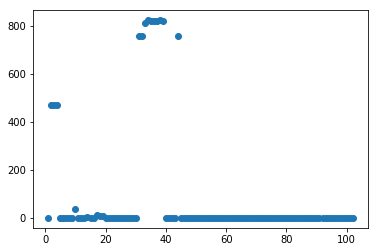

In [34]:
na_counts = boston_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

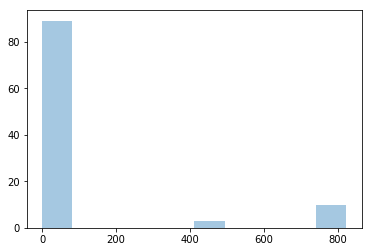

In [35]:
sns.distplot(na_counts.tolist(), kde=False);

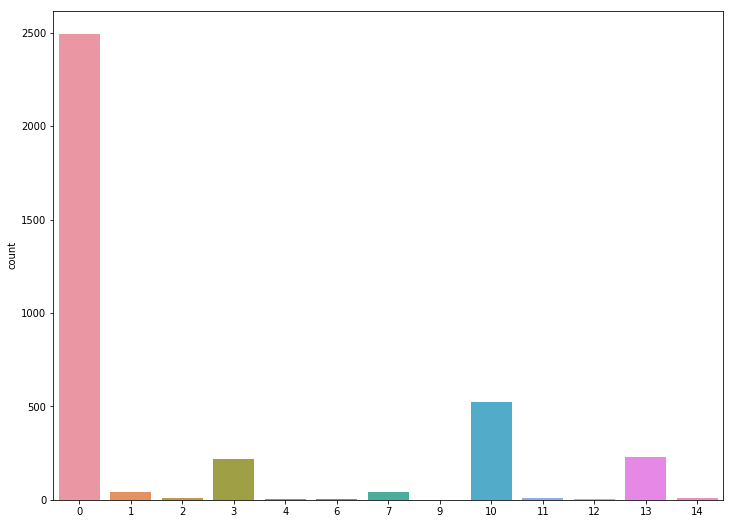

In [36]:
na_row_counts = boston_listings_n.isna().sum(axis=1)
fig, ax = plt.subplots(figsize=(4*3,3*3))
sns.countplot(na_row_counts,ax=ax);

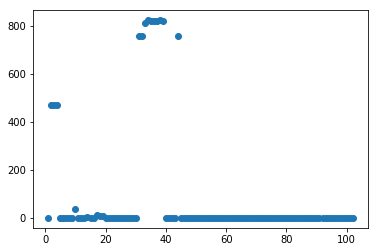

In [37]:
na_counts = boston_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

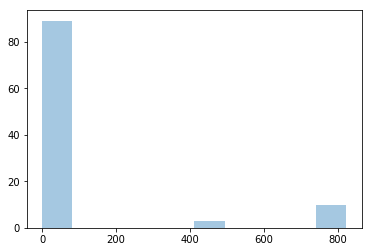

In [38]:
sns.distplot(na_counts.tolist(), kde=False);

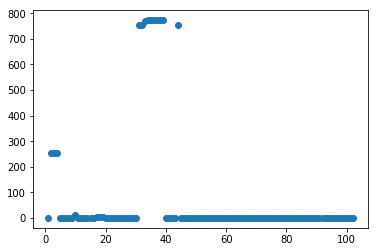

In [39]:
nanful = boston_listings_n.loc[na_row_counts[na_row_counts>8].index,:]
na_counts = nanful.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

In [40]:
na_counts.sort_values(ascending=False)[:15]

review_scores_cleanliness      773
review_scores_checkin          773
review_scores_value            773
review_scores_location         773
review_scores_communication    773
review_scores_accuracy         773
review_scores_rating           772
reviews_per_month              756
first_review                   756
last_review                    756
host_acceptance_rate           252
host_response_rate             252
host_response_time             252
zipcode                         13
beds                             3
dtype: int64

In [41]:
boston_listings_n['review_scores_missing'] = boston_listings_n.review_scores_value.isna()
boston_listings_n['review_scores_rating_missing'] = boston_listings_n.review_scores_rating.isna()
boston_listings_n['review_dates_missing'] = boston_listings_n.reviews_per_month.isna()

In [42]:
boston_listings_n.review_scores_value.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_location.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_communication.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_checkin.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_cleanliness.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_accuracy.fillna(0,axis=0,inplace=True)
boston_listings_n.review_scores_rating.fillna(0,axis=0,inplace=True)
boston_listings_n.reviews_per_month.fillna(0,axis=0,inplace=True)
boston_listings_n.last_review.fillna(boston_listings_n.last_review[boston_listings_n.last_review.notna()].min(),axis=0,inplace=True)
boston_listings_n.first_review.fillna(boston_listings_n.first_review[boston_listings_n.first_review.notna()].min(),axis=0,inplace=True)

After looking at the columns again and there distribution we find 3 columns that are outliers 

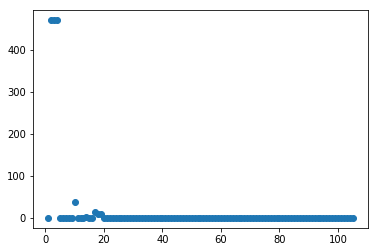

In [43]:
na_counts = boston_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

In [44]:
na_counts[na_counts>100]

host_response_time      471
host_response_rate      471
host_acceptance_rate    471
dtype: int64

In [45]:
cols_to_process = ['host_acceptance_rate','host_response_rate']
def perc_to_num(x):
    if pd.isna(x):
        return np.nan
    else:
        return int(x[:-1])
for col in cols_to_process:
    boston_listings_n[col] = boston_listings_n[col].apply(perc_to_num)

In [46]:
def time_to_dummy(x):
    d = {'within an hour': 0, 'within a few hours': 1 ,"within a day" : 2,'a few days or more':3}
    if pd.isna(x):
        return np.nan
    else:
        return d[x]
boston_listings_n['host_response_time'] = boston_listings_n['host_response_time'].apply(time_to_dummy)

In [47]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet,review_scores_missing,review_scores_rating_missing,review_dates_missing
0,2015-04-15,NaN,NaN,NaN,False,1,1,False,Roslindale,02131,42.282619,-71.133068,True,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,1,2,1125,2 weeks ago,0,0,0,0,0,2009-03-21,2010-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,moderate,False,1,0.00,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
1,2012-06-07,0.0,100.0,100.0,False,1,1,True,Roslindale,02131,42.286241,-71.134374,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,0,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,1,1.30,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2009-05-11,1.0,100.0,88.0,True,1,1,True,Roslindale,02131,42.292438,-71.135765,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,1,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,False,1,0.47,True,True,False,True,False,False,True,False,False,False,False,False,False,True,True,True,True,False,False,True,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-04-21,1.0,100.0,50.0,False,1,1,False,Roslindale,NaN,42.281106,-71.121021,False,House,Private room,4,1.0,1.0,2.0,Real Bed,$75.00,2,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,moderate,False,1,1.00,True,True,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,False,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2014-05-11,0.0,100.0,100.0,True,1,1,True,Roslindale,02131,42.284512,

In [48]:
boston_listings_n['host_response_missing'] = boston_listings_n.host_response_time.isna()

In [49]:
boston_listings_n.host_response_rate.fillna(boston_listings_n.host_response_rate.mean(),axis=0,inplace=True)
boston_listings_n.host_acceptance_rate.fillna(boston_listings_n.host_acceptance_rate.mean(),axis=0,inplace=True)
boston_listings_n.host_response_time.fillna(boston_listings_n.host_response_time.mode()[0],axis=0,inplace=True)

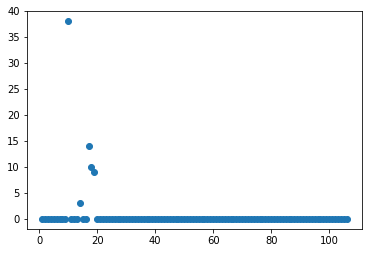

In [50]:
na_counts = boston_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

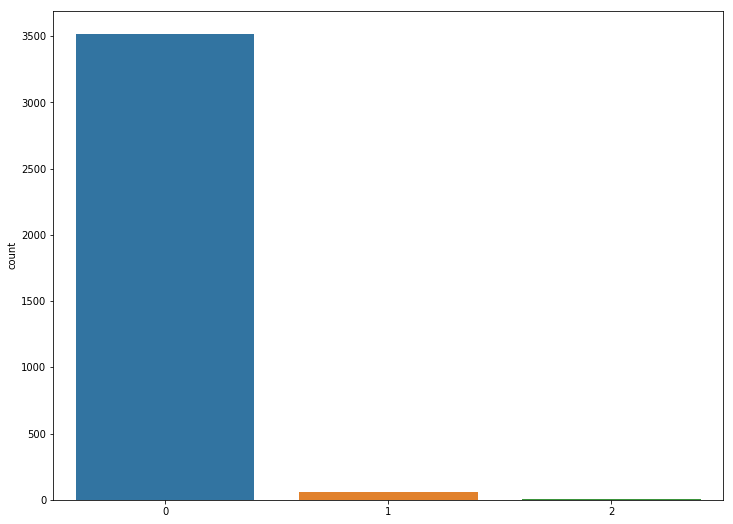

In [51]:
na_row_counts = boston_listings_n.isna().sum(axis=1)
fig, ax = plt.subplots(figsize=(4*3,3*3))
sns.countplot(na_row_counts,ax=ax);

In [52]:
boston_listings_n.drop(index = na_row_counts[na_row_counts>0].index,inplace=True)

In [53]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing
0,2015-04-15,0.0,94.989082,84.173089,False,1,1,False,Roslindale,02131,42.282619,-71.133068,True,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,1,2,1125,2 weeks ago,0,0,0,0,0,2009-03-21,2010-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,moderate,False,1,0.00,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True
1,2012-06-07,0.0,100.000000,100.000000,False,1,1,True,Roslindale,02131,42.286241,-71.134374,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,0,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,moderate,False,1,1.30,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2009-05-11,1.0,100.000000,88.000000,True,1,1,True,Roslindale,02131,42.292438,-71.135765,True,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,1,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,False,moderate,False,1,0.47,True,True,False,True,False,False,True,False,False,False,False,False,False,True,True,True,True,False,False,True,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2014-05-11,0.0,100.000000,100.000000,True,1,1,True,Roslindale,02131,42.284512,-71.136258,True,House,Private room,2,1.5,1.0,2.0,Real Bed,$79.00,1,2,31,2 weeks ago,13,34,59,334,29,2015-08-18,2016-09-01,99.0,10.0,10.0,10.0,10.0,9.0,10.0,False,flexible,False,1,2.25,True,True,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,True,False,True,True,False,True,False,True,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [54]:
object_cols = boston_listings_n.columns[boston_listings_n.dtypes == 'object']
object_cols

Index(['host_since', 'neighbourhood_cleansed', 'zipcode', 'property_type',
       'room_type', 'bed_type', 'price', 'calendar_updated', 'first_review',
       'last_review', 'cancellation_policy'],
      dtype='object')

In [56]:
dates_cols = ['host_since','first_review','last_review']
categoricals = ['neighbourhood_cleansed','property_type','bed_type','room_type','cancellation_policy']

In [57]:
for col in categoricals:
    print(boston_listings_n[col].value_counts())

Jamaica Plain              339
South End                  314
Back Bay                   295
Fenway                     284
Dorchester                 262
Allston                    257
Beacon Hill                193
Brighton                   183
South Boston               173
Downtown                   169
East Boston                146
North End                  138
Roxbury                    138
Mission Hill               123
Charlestown                111
South Boston Waterfront     81
Chinatown                   71
Roslindale                  55
West End                    49
West Roxbury                46
Hyde Park                   31
Bay Village                 24
Mattapan                    24
Longwood Medical Area        7
Leather District             5
Name: neighbourhood_cleansed, dtype: int64
Apartment          2566
House               552
Condominium         229
Townhouse            53
Loft                 38
Bed & Breakfast      37
Other                17
Boat          

In [58]:
d = dict(boston_listings_n.property_type.value_counts())
boston_listings_n.property_type = boston_listings_n.property_type.map(lambda x: x if d[x]> 10 else 'Other')

In [59]:
for feature in categoricals:
    dummies = pd.get_dummies(boston_listings_n[feature],prefix = feature)
    boston_listings_n[dummies.columns] = dummies
    boston_listings_n.drop(feature,axis=1,inplace=True)

In [60]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,2015-04-15,0.0,94.989082,84.173089,False,1,1,False,02131,42.282619,-71.133068,True,4,1.5,2.0,3.0,$250.00,1,2,1125,2 weeks ago,0,0,0,0,0,2009-03-21,2010-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0.00,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,2012-06-07,0.0,100.000000,100.000000,False,1,1,True,02131,42.286241,-71.134374,True,2,1.0,1.0,1.0,$65.00,0,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,False,1,1.30,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [61]:
boston_listings_n.zipcode.value_counts()

02116          385
02130          330
02118          239
02215          235
02134          231
02114          231
02127          180
02135          172
02115          164
02128          146
02125          126
02120          115
02113          100
02111           99
02119           99
02129           90
02124           79
02210           75
02108           70
02131           65
02109           51
02122           43
02132           37
02136           29
02121           29
02126           24
02110           12
02145           12
02446            8
02143            7
02139            6
02138            6
02445            5
02467            5
02163            3
02141            3
02134-1704       1
02186            1
02472            1
02108 02111      1
02169            1
02142            1
02218            1
Name: zipcode, dtype: int64

In [63]:
ind = boston_listings_n.zipcode[boston_listings_n.zipcode == '02134-1704'].index
boston_listings_n.loc[ind,'zipcode'] = '02134'
ind = boston_listings_n.zipcode[boston_listings_n.zipcode == '02108 02111'].index
boston_listings_n.loc[ind,'zipcode'] = '02108'

In [64]:
boston_listings_n.zipcode = boston_listings_n.zipcode.astype(int)
boston_listings_n.zipcode -= boston_listings_n.zipcode.min()

In [65]:
boston_listings_n.calendar_updated.value_counts()

today            825
a week ago       325
2 weeks ago      301
3 weeks ago      215
yesterday        174
4 days ago       164
2 months ago     162
4 weeks ago      156
5 days ago       130
3 months ago     128
5 weeks ago      122
3 days ago       100
2 days ago        98
4 months ago      84
6 weeks ago       79
5 months ago      56
7 months ago      41
10 months ago     37
6 days ago        36
1 week ago        36
7 weeks ago       35
9 months ago      35
8 months ago      32
6 months ago      32
14 months ago     19
13 months ago     19
11 months ago     17
never             16
12 months ago     12
17 months ago      9
15 months ago      8
16 months ago      7
25 months ago      2
18 months ago      2
30 months ago      1
20 months ago      1
22 months ago      1
23 months ago      1
Name: calendar_updated, dtype: int64

In [66]:
def process_update(x):
    if x == 'today':
        return 0 
    if x == 'yesterday':
        return 1
    if x == 'a week ago' or x == '1 week ago':
        return 7
    if x.endswith(' days ago'):
        return int(x[:x.index(' days ago')])
    if x.endswith(' weeks ago'):
        return int(x[:x.index(' weeks ago')])*7
    if x.endswith(' months ago'):
        return int(x[:x.index(' months ago')])*30
    if x =='never':
        return 999999
    else:
        print(x)
        raise ValueError

In [67]:
boston_listings_n.calendar_updated = boston_listings_n.calendar_updated.apply(process_update)

In [68]:
boston_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,SmokeDetector,FireExtinguisher,Essentials,Shampoo,LaptopFriendlyWorkspace,Internet,AirConditioning,PetsAllowed,CarbonMonoxideDetector,LockonBedroomDoor,Hangers,HairDryer,Iron,CableTV,FirstAidKit,SafetyCard,translationmissingenhostingamenity49,translationmissingenhostingamenity50,Gym,Breakfast,IndoorFireplace,Cats,24HourCheckin,HotTub,BuzzerWirelessIntercom,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,2015-04-15,0.0,94.989082,84.173089,False,1,1,False,23,42.282619,-71.133068,True,4,1.5,2.0,3.0,$250.00,1,2,1125,14,0,0,0,0,0,2009-03-21,2010-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0.00,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,2012-06-07,0.0,100.000000,100.000000,False,1,1,True,23,42.286241,-71.134374,True,2,1.0,1.0,1.0,$65.00,0,2,15,7,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,True,False,1,1.30,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [69]:
boston_listings_n.shape

(3518, 146)

In [70]:
for date_col in dates_cols:
    dates_list = list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),boston_listings_n[date_col]))
    min_date = min(list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),boston_listings_n[date_col])))
    boston_listings_n[date_col] = list(map(lambda x: (x - min_date).days, dates_list))

In [71]:
boston_listings_n[dates_cols].head()

,host_since,first_review,last_review
0,2346,0,0
1,1304,1898,2128
2,181,120,2120
4,2007,2341,2147
5,2689,2587,2143


In [72]:
b_listings_features_cols = boston_listings_n.columns.tolist()
b_listings_features_cols.pop(b_listings_features_cols.index('price'));

In [73]:
b_listings_features = boston_listings_n[b_listings_features_cols]
b_listings_labels = boston_listings_n['price'].map(lambda x: float(''.join(e for e in x if e.isalnum()))/100) ## from $## to ## 

In [74]:
Y = b_listings_labels.to_numpy()
print(Y.shape)

(3518,)


In [75]:
X = b_listings_features.to_numpy(dtype = np.float64)
print(X.shape)

(3518, 145)


In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
pca = PCA()
XPca = pca.fit_transform(scalar.fit_transform(X))

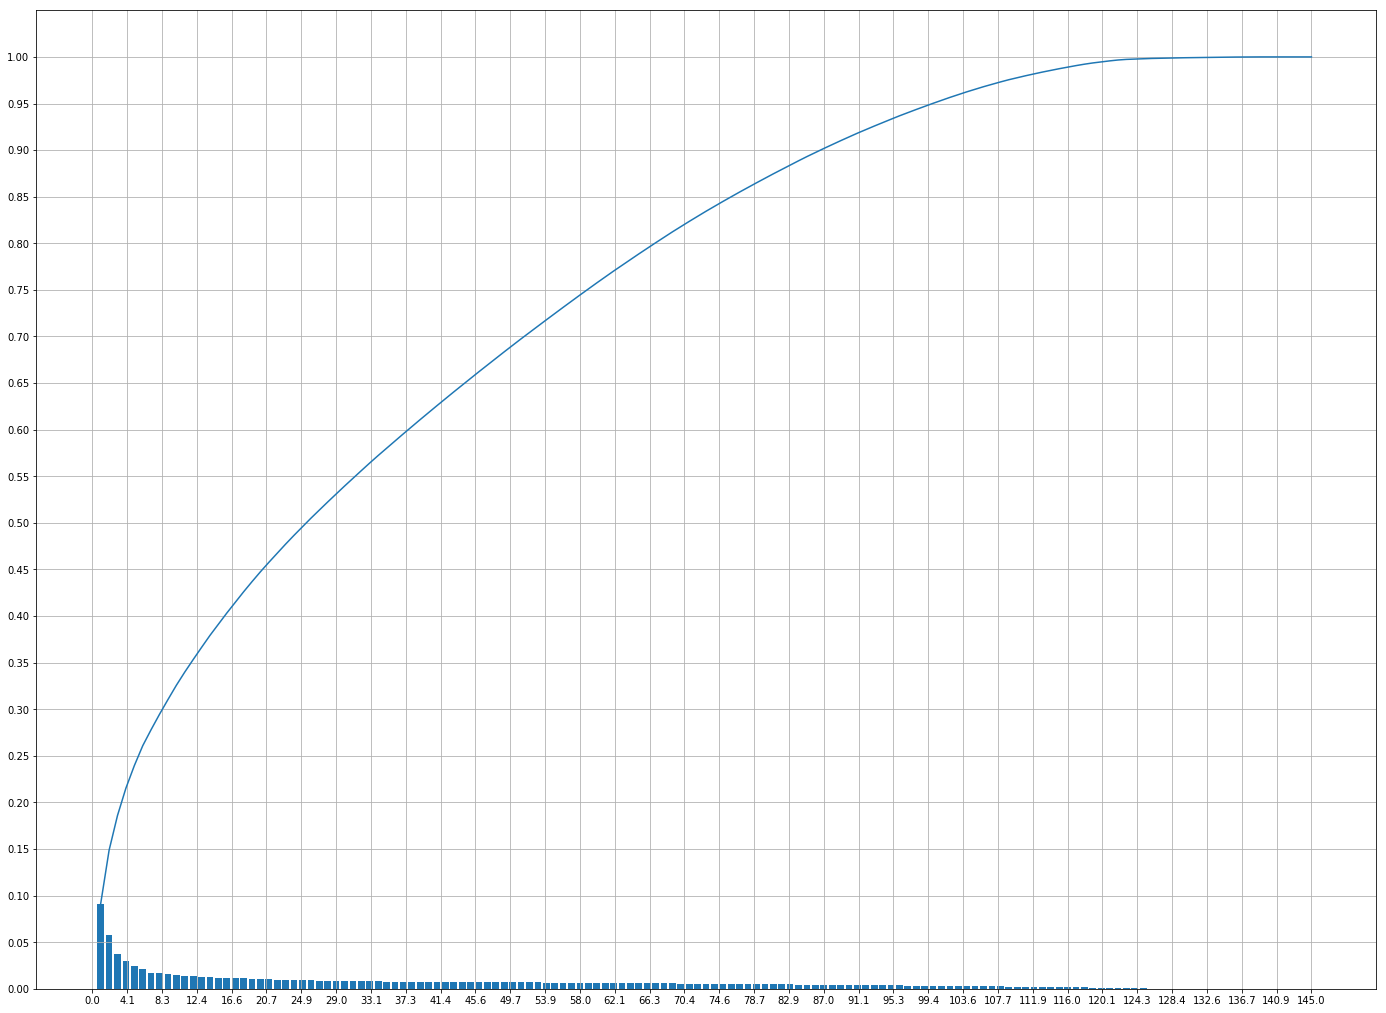

In [78]:
# Investigate the variance accounted for by each principal component.
ratios = pca.explained_variance_ratio_
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*6,3*6))
ax.bar(list(range(1,len(ratios)+1)),ratios)
ax.plot(list(range(1,len(ratios)+1)),np.cumsum(ratios))
ax.grid(True)
ax.set_yticks(np.linspace(0,1,num=21))
ax.set_xticks(np.linspace(0,145,num=145//4));

We find that to Preserve around 90% of the variance we will take only 87 dimensions

In [80]:
def comp_weights(index,pca):
    comp = pca.components_[index]
    comp = pd.DataFrame(comp).transpose()
    comp.columns = b_listings_features.columns
    comp.index = ['weights']
    comp = comp.sort_values(by = 'weights', axis =1,ascending=False )
    return comp
comp_weights(0,pca)

,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_listings_count,host_total_listings_count,calculated_host_listings_count,Gym,host_response_missing,ElevatorinBuilding,availability_30,Doorman,cancellation_policy_flexible,Pool,zipcode,neighbourhood_cleansed_Fenway,availability_60,property_type_Apartment,host_since,availability_90,neighbourhood_cleansed_West End,latitude,neighbourhood_cleansed_Chinatown,cancellation_policy_super_strict_30,jumio,calendar_updated,neighbourhood_cleansed_Mission Hill,weibo,property_type_Other,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_South Boston Waterfront,room_type_Entire home/apt,Dryer,minimum_nights,manualoffline,Washer,neighbourhood_cleansed_Allston,manualonline,bathrooms,bed_type_Real Bed,FamilyKidFriendly,room_type_Shared room,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Charlestown,LockonBedroomDoor,SmokingAllowed,host_response_time,neighbourhood_cleansed_Bay Village,bed_type_Couch,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Back Bay,TV,require_guest_phone_verification,WasherDryer,Kitchen,bedrooms,WheelchairAccessible,neighbourhood_cleansed_Leather District,translationmissingenhostingamenity50,FreeParkingonStreet,property_type_Bed & Breakfast,neighbourhood_cleansed_West Roxbury,PaidParkingOffPremises,linkedin,bed_type_Airbed,HotTub,neighbourhood_cleansed_Mattapan,CableTV,accommodates,maximum_nights,translationmissingenhostingamenity49,neighbourhood_cleansed_Hyde Park,AirConditioning,is_location_exact,property_type_Boat,property_type_Loft,google,PetsAllowed,sentid,neighbourhood_cleansed_Roxbury,bed_type_Pull-out Sofa,SuitableforEvents,Otherpets,property_type_Condominium,phone,IndoorFireplace,Breakfast,property_type_Townhouse,beds,Essentials,neighbourhood_cleansed_South End,neighbourhood_cleansed_North End,longitude,neighbourhood_cleansed_Roslindale,bed_type_Futon,cancellation_policy_strict,Iron,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Dorchester,instant_bookable,amex,LaptopFriendlyWorkspace,room_type_Private room,HairDryer,facebook,Hangers,Cats,neighbourhood_cleansed_South Boston,email,Heating,Shampoo,availability_365,neighbourhood_cleansed_East Boston,24HourCheckin,FreeParkingonPremises,Dogs,BuzzerWirelessIntercom,WirelessInternet,neighbourhood_cleansed_Jamaica Plain,Petsliveonthisproperty,property_type_House,host_response_rate,Internet,guests_included,SafetyCard,cancellation_policy_moderate,host_identity_verified,host_acceptance_rate,kba,FirstAidKit,FireExtinguisher,host_is_superhost,CarbonMonoxideDetector,SmokeDetector,number_of_reviews,reviews_per_month,reviews,first_review,last_review,review_scores_location,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,review_scores_value,review_scores_checkin,review_scores_communication
weights,0.262211,0.261986,0.255661,0.099542,0.099542,0.096208,0.09158,0.081202,0.075268,0.058411,0.05466,0.054062,0.051391,0.049842,0.046887,0.046086,0.03655,0.03591,0.032745,0.032405,0.031483,0.031426,0.026784,0.023508,0.023156,0.020505,0.020379,0.019702,0.019245,0.018421,0.017791,0.017492,0.017479,0.0173,0.015574,0.01499,0.012572,0.012495,0.012288,0.011674,0.011235,0.009597,0.008083,0.007309,0.005998,0.005508,0.005365,0.005324,0.005086,0.004713,0.004602,0.004474,0.003959,0.003873,0.003595,0.00326,0.002669,0.002466,0.00207,0.001291,0.000981,0.000824,0.000782,0.000324,0.000305,-0.000927,-0.002622,-0.003426,-0.003972,-0.004532,-0.004592,-0.005236,-0.005357,-0.005865,-0.005868,-0.005997,-0.006402,-0.006592,-0.006977,-0.007075,-0.007131,-0.007617,-0.008963,-0.010794,-0.010846,-0.012352,-0.012581,-0.012674,-0.014133,-0.014784,-0.015596,-0.015839,-0.016333,-0.016396,-0.016781,-0.017612,-0.018386,-0.018479,-0.018676,-0.019853,-0.020434,-0.021374,-0.021405,-0.021672,-0.022364,-0.023677,-0.024214,-0.024531,-0.025065,-0.0251,-0.025132,-0.025494,-0.029523,-0.029687,-0.030728,-0.032491,-0.033076,-0.033811,-0.037103,-0.037169,-0.038093,-0.039135,-0.04126,-0.042224,-0.04

In [81]:
comp_weights(1,pca)

,host_total_listings_count,host_listings_count,calculated_host_listings_count,room_type_Entire home/apt,Gym,ElevatorinBuilding,CableTV,accommodates,availability_30,availability_60,TV,availability_90,FamilyKidFriendly,Doorman,Pool,AirConditioning,Internet,24HourCheckin,require_guest_phone_verification,beds,bedrooms,host_identity_verified,cancellation_policy_super_strict_30,cancellation_policy_strict,manualoffline,jumio,reviews,Iron,Washer,Dryer,manualonline,latitude,HairDryer,Kitchen,bathrooms,Shampoo,Heating,property_type_Apartment,longitude,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_West End,Essentials,availability_365,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_Fenway,review_scores_cleanliness,review_scores_location,guests_included,neighbourhood_cleansed_Downtown,WirelessInternet,is_location_exact,bed_type_Real Bed,review_scores_rating,Hangers,neighbourhood_cleansed_Back Bay,review_scores_accuracy,WheelchairAccessible,email,review_scores_communication,review_scores_checkin,review_scores_value,host_response_time,last_review,LaptopFriendlyWorkspace,zipcode,PetsAllowed,BuzzerWirelessIntercom,first_review,amex,phone,minimum_nights,neighbourhood_cleansed_South End,property_type_Boat,PaidParkingOffPremises,IndoorFireplace,host_response_rate,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_North End,neighbourhood_cleansed_Leather District,property_type_Loft,maximum_nights,WasherDryer,FreeParkingonStreet,neighbourhood_cleansed_Beacon Hill,property_type_Condominium,neighbourhood_cleansed_South Boston,sentid,number_of_reviews,SuitableforEvents,Otherpets,host_is_superhost,kba,neighbourhood_cleansed_East Boston,instant_bookable,cancellation_policy_moderate,SafetyCard,google,bed_type_Couch,neighbourhood_cleansed_Charlestown,reviews_per_month,weibo,neighbourhood_cleansed_Mission Hill,property_type_Other,linkedin,bed_type_Pull-out Sofa,CarbonMonoxideDetector,property_type_Townhouse,Dogs,neighbourhood_cleansed_Roxbury,FireExtinguisher,calendar_updated,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,neighbourhood_cleansed_Hyde Park,bed_type_Futon,HotTub,Cats,bed_type_Airbed,SmokingAllowed,room_type_Shared room,facebook,neighbourhood_cleansed_Brighton,review_dates_missing,neighbourhood_cleansed_Allston,Petsliveonthisproperty,Breakfast,neighbourhood_cleansed_Jamaica Plain,review_scores_missing,SmokeDetector,translationmissingenhostingamenity50,review_scores_rating_missing,FirstAidKit,FreeParkingonPremises,neighbourhood_cleansed_Dorchester,host_since,translationmissingenhostingamenity49,property_type_House,LockonBedroomDoor,host_response_missing,host_acceptance_rate,cancellation_policy_flexible,room_type_Private room
weights,0.248495,0.248495,0.242558,0.202886,0.199411,0.17716,0.171086,0.170253,0.165954,0.157341,0.150801,0.149326,0.14708,0.141658,0.137378,0.135428,0.129265,0.122929,0.121886,0.117592,0.116075,0.109541,0.108621,0.107376,0.105872,0.101621,0.100781,0.100219,0.096401,0.096096,0.094404,0.092171,0.089842,0.086337,0.08354,0.08306,0.082056,0.080524,0.080408,0.077041,0.076856,0.063945,0.06355,0.063338,0.05906,0.056654,0.056335,0.056207,0.054034,0.052661,0.05167,0.050889,0.049419,0.04798,0.046586,0.045399,0.045113,0.042737,0.042656,0.04253,0.041925,0.040851,0.037719,0.037361,0.034854,0.033507,0.028842,0.028001,0.026244,0.01762,0.0157,0.010054,0.009196,0.009127,0.008182,0.006456,0.003363,0.002865,0.002735,0.002193,0.00186,0.001534,0.001291,-0.000572,-0.00071,-0.001468,-0.001732,-0.003928,-0.004255,-0.004612,-0.004789,-0.005862,-0.006979,-0.008022,-0.009339,-0.009683,-0.009912,-0.011352,-0.011933,-0.013585,-0.014022,-0.015231,-0.015374,-0.015732,-0.016509,-0.017027,-0.018385,-0.019084,-0.020086,-0.021994,-0.022568,-0.025768,-0.026579,-0.026713,-0.027041,-0.030521,-0.030553,-0.031695,-0.031903,-0.033616,-0.034549,-0.036438,-0.038894,-0.03927,-0.043428,-0.044077,-0.044

In [82]:
comp_weights(2,pca)

,cancellation_policy_super_strict_30,calculated_host_listings_count,host_listings_count,host_total_listings_count,host_response_time,require_guest_phone_verification,availability_30,availability_60,property_type_Apartment,review_scores_location,availability_90,review_scores_checkin,review_scores_communication,translationmissingenhostingamenity49,translationmissingenhostingamenity50,review_scores_accuracy,review_scores_rating,review_scores_value,room_type_Private room,availability_365,last_review,reviews,review_scores_cleanliness,jumio,Gym,first_review,room_type_Shared room,neighbourhood_cleansed_Fenway,ElevatorinBuilding,Pool,minimum_nights,Doorman,cancellation_policy_flexible,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_West End,bed_type_Futon,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Mission Hill,bed_type_Airbed,neighbourhood_cleansed_Chinatown,calendar_updated,bed_type_Couch,bed_type_Pull-out Sofa,zipcode,neighbourhood_cleansed_Hyde Park,property_type_Other,Otherpets,WasherDryer,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Beacon Hill,Cats,property_type_Bed & Breakfast,manualonline,neighbourhood_cleansed_Roxbury,phone,latitude,weibo,maximum_nights,longitude,host_identity_verified,Petsliveonthisproperty,neighbourhood_cleansed_South End,neighbourhood_cleansed_Longwood Medical Area,SmokingAllowed,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_South Boston Waterfront,property_type_Boat,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_West Roxbury,sentid,property_type_Loft,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Leather District,is_location_exact,WheelchairAccessible,neighbourhood_cleansed_Bay Village,manualoffline,neighbourhood_cleansed_Allston,PaidParkingOffPremises,Dogs,CableTV,HotTub,email,neighbourhood_cleansed_Charlestown,host_response_missing,property_type_House,FreeParkingonStreet,neighbourhood_cleansed_North End,number_of_reviews,cancellation_policy_strict,facebook,property_type_Townhouse,linkedin,PetsAllowed,Washer,Dryer,bed_type_Real Bed,neighbourhood_cleansed_Jamaica Plain,cancellation_policy_moderate,neighbourhood_cleansed_South Boston,SuitableforEvents,Kitchen,IndoorFireplace,bathrooms,Breakfast,google,host_response_rate,BuzzerWirelessIntercom,LockonBedroomDoor,kba,amex,Internet,reviews_per_month,host_is_superhost,room_type_Entire home/apt,FreeParkingonPremises,TV,AirConditioning,host_since,review_scores_missing,review_dates_missing,review_scores_rating_missing,property_type_Condominium,instant_bookable,Heating,WirelessInternet,FamilyKidFriendly,host_acceptance_rate,SafetyCard,bedrooms,FirstAidKit,guests_included,accommodates,FireExtinguisher,beds,Essentials,24HourCheckin,Shampoo,CarbonMonoxideDetector,SmokeDetector,LaptopFriendlyWorkspace,Iron,Hangers,HairDryer
weights,0.144585,0.138787,0.133896,0.133896,0.110225,0.086508,0.083932,0.077823,0.075214,0.074554,0.070733,0.069381,0.068049,0.066392,0.06571,0.065227,0.065168,0.063107,0.062544,0.060018,0.05956,0.058735,0.058608,0.051633,0.051514,0.04682,0.04565,0.04402,0.041934,0.036738,0.036628,0.036333,0.030316,0.029349,0.02889,0.024374,0.023874,0.023425,0.022918,0.021053,0.020733,0.019762,0.018008,0.014919,0.011767,0.009663,0.009427,0.008223,0.007505,0.006796,0.006701,0.006413,0.005103,0.003861,0.00182,0.001358,0.00124,0.000771,0.000416,0.000289,-0.000236,-0.000574,-0.000613,-0.001914,-0.002035,-0.002861,-0.003298,-0.003319,-0.003898,-0.00692,-0.006928,-0.007714,-0.008395,-0.009906,-0.010019,-0.012498,-0.012716,-0.012801,-0.013241,-0.01358,-0.014113,-0.015605,-0.017042,-0.017238,-0.017635,-0.022125,-0.02372,-0.026307,-0.027187,-0.028532,-0.0299,-0.030917,-0.034417,-0.036155,-0.03952,-0.040756,-0.042185,-0.042377,-0.044114,-0.044888,-0.046352,-0.046795,-0.050268,-0.050473,-0.052566,-0.052891,-0.054509,-0.060979,-0.063803,-0.06658,-0.068844,-0.07047,-0.072656,-0.074524,-0.074977,-0.075623,-0.077065,-0.07808,-0.079897,-0.080915,-0.081303,-0.081801,-0.083508,-0.085785,-0.08

In [83]:
comp_weights(3,pca)

,availability_90,availability_60,availability_30,property_type_House,availability_365,room_type_Private room,FreeParkingonPremises,Petsliveonthisproperty,FirstAidKit,Cats,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Dorchester,Dogs,Breakfast,bathrooms,neighbourhood_cleansed_Roslindale,host_identity_verified,neighbourhood_cleansed_West Roxbury,LockonBedroomDoor,host_listings_count,host_total_listings_count,neighbourhood_cleansed_Mattapan,SafetyCard,require_guest_phone_verification,calculated_host_listings_count,kba,neighbourhood_cleansed_Hyde Park,number_of_reviews,Shampoo,property_type_Bed & Breakfast,host_is_superhost,zipcode,email,reviews,HairDryer,Hangers,CarbonMonoxideDetector,IndoorFireplace,neighbourhood_cleansed_Roxbury,calendar_updated,property_type_Townhouse,Iron,bedrooms,manualonline,Gym,FireExtinguisher,bed_type_Futon,Pool,neighbourhood_cleansed_Brighton,cancellation_policy_moderate,FamilyKidFriendly,bed_type_Airbed,translationmissingenhostingamenity50,cancellation_policy_super_strict_30,reviews_per_month,room_type_Shared room,LaptopFriendlyWorkspace,instant_bookable,neighbourhood_cleansed_West End,HotTub,manualoffline,linkedin,Essentials,translationmissingenhostingamenity49,FreeParkingonStreet,Otherpets,review_dates_missing,neighbourhood_cleansed_Chinatown,property_type_Other,WirelessInternet,SmokingAllowed,beds,phone,review_scores_missing,property_type_Boat,review_scores_rating_missing,cancellation_policy_strict,host_response_time,host_response_rate,bed_type_Pull-out Sofa,bed_type_Couch,SuitableforEvents,jumio,24HourCheckin,neighbourhood_cleansed_Bay Village,minimum_nights,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Allston,google,WasherDryer,Heating,neighbourhood_cleansed_South Boston,sentid,weibo,property_type_Condominium,PetsAllowed,SmokeDetector,guests_included,neighbourhood_cleansed_Mission Hill,Washer,neighbourhood_cleansed_Fenway,PaidParkingOffPremises,neighbourhood_cleansed_Charlestown,is_location_exact,neighbourhood_cleansed_East Boston,maximum_nights,last_review,neighbourhood_cleansed_Leather District,Dryer,facebook,neighbourhood_cleansed_South Boston Waterfront,host_acceptance_rate,review_scores_checkin,review_scores_communication,review_scores_cleanliness,review_scores_rating,amex,review_scores_accuracy,review_scores_value,accommodates,property_type_Loft,Doorman,Internet,review_scores_location,host_since,first_review,AirConditioning,bed_type_Real Bed,cancellation_policy_flexible,CableTV,WheelchairAccessible,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Back Bay,ElevatorinBuilding,TV,neighbourhood_cleansed_South End,neighbourhood_cleansed_North End,neighbourhood_cleansed_Beacon Hill,Kitchen,BuzzerWirelessIntercom,longitude,host_response_missing,room_type_Entire home/apt,property_type_Apartment,latitude
weights,0.301105,0.29702,0.274455,0.245061,0.236314,0.210353,0.192104,0.152828,0.129021,0.126156,0.110467,0.10942,0.107053,0.10652,0.091017,0.090305,0.086416,0.083559,0.082445,0.079848,0.079848,0.07747,0.073784,0.073452,0.073363,0.06889,0.067923,0.066508,0.063421,0.063012,0.05885,0.05617,0.05322,0.050012,0.048703,0.047551,0.04611,0.044664,0.042912,0.042312,0.042012,0.041619,0.04127,0.039032,0.035455,0.034466,0.034383,0.031287,0.031115,0.030429,0.030173,0.029537,0.029489,0.028379,0.027167,0.025435,0.025339,0.024169,0.022249,0.019727,0.018899,0.01878,0.018407,0.018136,0.017851,0.017501,0.017425,0.016221,0.015892,0.015661,0.015537,0.015523,0.014611,0.014379,0.014237,0.013922,0.0132,0.01138,0.011306,0.011199,0.01112,0.008615,0.00738,0.006323,0.005995,0.002736,0.002544,0.0015,0.001045,-0.000052,-0.000085,-0.000124,-0.001271,-0.00174,-0.00198,-0.00357,-0.005435,-0.005677,-0.006376,-0.006917,-0.009498,-0.010228,-0.01034,-0.010851,-0.011199,-0.011371,-0.011538,-0.01203,-0.012083,-0.012566,-0.013769,-0.014263,-0.014764,-0.015118,-0.015281,-0.016837,-0.016895,-0.018169,-0.018799,-0.019841,-0.023545,-0.029747,-0.032758,-0.033881,-0.03427,-0.042087,-0.045175,-0.046705,-

In [84]:
comp_weights(4,pca)

,bedrooms,beds,accommodates,guests_included,bathrooms,room_type_Entire home/apt,FreeParkingonPremises,property_type_House,FamilyKidFriendly,neighbourhood_cleansed_Jamaica Plain,IndoorFireplace,bed_type_Real Bed,Dogs,Petsliveonthisproperty,host_response_missing,TV,CableTV,property_type_Boat,cancellation_policy_super_strict_30,kba,Cats,neighbourhood_cleansed_Roslindale,WasherDryer,PetsAllowed,FireExtinguisher,neighbourhood_cleansed_West Roxbury,availability_365,facebook,Dryer,Washer,is_location_exact,Otherpets,neighbourhood_cleansed_Hyde Park,Kitchen,neighbourhood_cleansed_North End,Internet,host_response_time,SuitableforEvents,require_guest_phone_verification,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_Charlestown,SafetyCard,cancellation_policy_flexible,AirConditioning,neighbourhood_cleansed_Roxbury,cancellation_policy_strict,neighbourhood_cleansed_South End,neighbourhood_cleansed_Dorchester,property_type_Other,number_of_reviews,review_scores_missing,review_scores_rating_missing,review_dates_missing,neighbourhood_cleansed_Bay Village,FirstAidKit,neighbourhood_cleansed_Leather District,maximum_nights,host_is_superhost,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Brighton,minimum_nights,calendar_updated,Breakfast,phone,property_type_Condominium,review_scores_rating,review_scores_communication,property_type_Bed & Breakfast,review_scores_accuracy,neighbourhood_cleansed_Beacon Hill,review_scores_checkin,sentid,review_scores_value,review_scores_cleanliness,neighbourhood_cleansed_Longwood Medical Area,BuzzerWirelessIntercom,PaidParkingOffPremises,review_scores_location,property_type_Loft,FreeParkingonStreet,SmokeDetector,neighbourhood_cleansed_West End,email,Heating,CarbonMonoxideDetector,host_response_rate,last_review,bed_type_Couch,weibo,WheelchairAccessible,HotTub,SmokingAllowed,neighbourhood_cleansed_Mission Hill,WirelessInternet,neighbourhood_cleansed_Downtown,longitude,host_identity_verified,amex,property_type_Townhouse,reviews,availability_30,neighbourhood_cleansed_East Boston,bed_type_Pull-out Sofa,bed_type_Futon,neighbourhood_cleansed_Chinatown,availability_90,availability_60,room_type_Shared room,neighbourhood_cleansed_South Boston Waterfront,Pool,manualonline,host_total_listings_count,host_listings_count,host_acceptance_rate,linkedin,cancellation_policy_moderate,instant_bookable,calculated_host_listings_count,first_review,neighbourhood_cleansed_Allston,translationmissingenhostingamenity50,google,Doorman,zipcode,translationmissingenhostingamenity49,manualoffline,bed_type_Airbed,Gym,neighbourhood_cleansed_Fenway,jumio,property_type_Apartment,ElevatorinBuilding,reviews_per_month,latitude,Essentials,24HourCheckin,room_type_Private room,Shampoo,LockonBedroomDoor,host_since,Iron,HairDryer,LaptopFriendlyWorkspace,Hangers
weights,0.290809,0.28977,0.286048,0.204516,0.174501,0.150547,0.135858,0.118914,0.111949,0.109868,0.105454,0.102946,0.100356,0.094418,0.080603,0.072033,0.071346,0.070273,0.061855,0.061272,0.060095,0.058761,0.052857,0.052508,0.050711,0.050635,0.047698,0.046968,0.045174,0.044646,0.044155,0.042295,0.039938,0.039506,0.032969,0.029505,0.028431,0.026331,0.025673,0.025454,0.023907,0.022681,0.021055,0.020846,0.020309,0.019022,0.018934,0.015473,0.013505,0.011673,0.011594,0.007097,0.006866,0.006653,0.005273,0.004485,0.003366,0.002749,0.001492,0.001408,0.001268,0.000894,0.000077,-0.004196,-0.005328,-0.005576,-0.006112,-0.006207,-0.00631,-0.006423,-0.006713,-0.007237,-0.007321,-0.00739,-0.008246,-0.008353,-0.009189,-0.009332,-0.012822,-0.012828,-0.013417,-0.015438,-0.017936,-0.019119,-0.019491,-0.019684,-0.019767,-0.021258,-0.023237,-0.024095,-0.024542,-0.025285,-0.025575,-0.026717,-0.02939,-0.030992,-0.03118,-0.034186,-0.035787,-0.037004,-0.037385,-0.039552,-0.041761,-0.045138,-0.045731,-0.046217,-0.047954,-0.048366,-0.050618,-0.051441,-0.055623,-0.058962,-0.060303,-0.060303,-0.061668,-0.062232,-0.063405,-0.066131,-0.066643,-0.069453,-0.06956,-0.07295,-0.073448,-0.07550

## 4. Modeling

In [85]:
X_train, X_test, y_train, y_test = train_test_split(XPca, Y, test_size=500, random_state=555)

I will try SVMs, linear regression, and a GradientBoostedTrees model to get a spectrum of all the types of models.

In [86]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner,X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train,y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first  training samples which is y_train
    results['mae_train'] = mean_absolute_error(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['mae_test'] = mean_absolute_error(y_test,predictions_test)
    
    # Compute F-score on training samples using fbeta_score()
    results['r2_train'] = r2_score(y_train,predictions_train)
        
    # Compute F-score on the test set which is y_test
    results['r2_test'] = r2_score(y_test,predictions_test)
       
    # Success
    print("{} trained".format(learner.__class__.__name__))
        
    # Return the results
    return results

In [87]:
import matplotlib.patches as mpatches

def evaluate(results):
    """
    Visualization code to display results of various learners.
    inputs:
      - learners: a list of supervised learners
      - results: a dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 1
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'mae_train', 'r2_train', 'pred_time', 'mae_test', 'r2_test']):
            # Creative plot code
            ax[j//3, j%3].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
#             ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("MAE Score")
    ax[0, 2].set_ylabel("R2-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("MAE Score")
    ax[1, 2].set_ylabel("R2-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("MAE Score on Training Subset")
    ax[0, 2].set_title("R2-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("MAE Score on Testing Set")
    ax[1, 2].set_title("R2-score on Testing Set")

    
    # Set y-limits for score panels
#     ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
#     ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [89]:
svr = LSVR()
gbr = GBR()
lr = LR()

LinearSVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


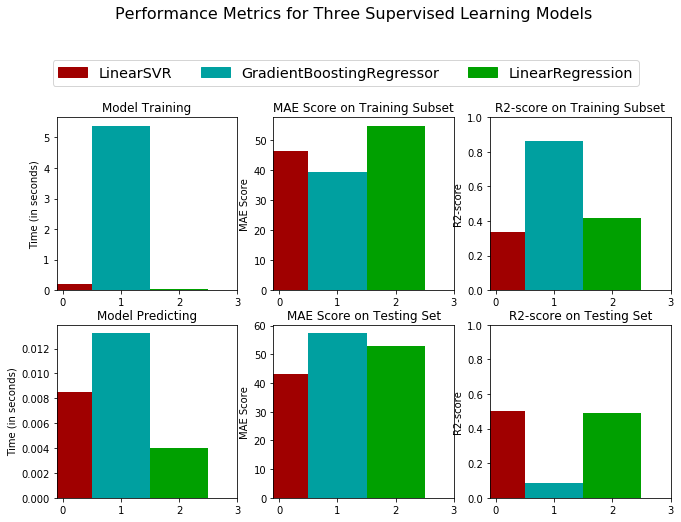

In [90]:
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [91]:
results

{'LinearSVR': {'train_time': 0.21979284286499023,
  'pred_time': 0.008481025695800781,
  'mae_train': 46.41204016576806,
  'mae_test': 43.11069299643921,
  'r2_train': 0.33547796560616805,
  'r2_test': 0.5019910000557304},
 'GradientBoostingRegressor': {'train_time': 5.3886332511901855,
  'pred_time': 0.013248920440673828,
  'mae_train': 39.3135408427882,
  'mae_test': 57.415810240938725,
  'r2_train': 0.8643017026665334,
  'r2_test': 0.08464754080274328},
 'LinearRegression': {'train_time': 0.0475153923034668,
  'pred_time': 0.003983736038208008,
  'mae_train': 54.793805559069746,
  'mae_test': 53.022838954588934,
  'r2_train': 0.41484995956974635,
  'r2_test': 0.4910542021280139}}

In [93]:
top_features = 10

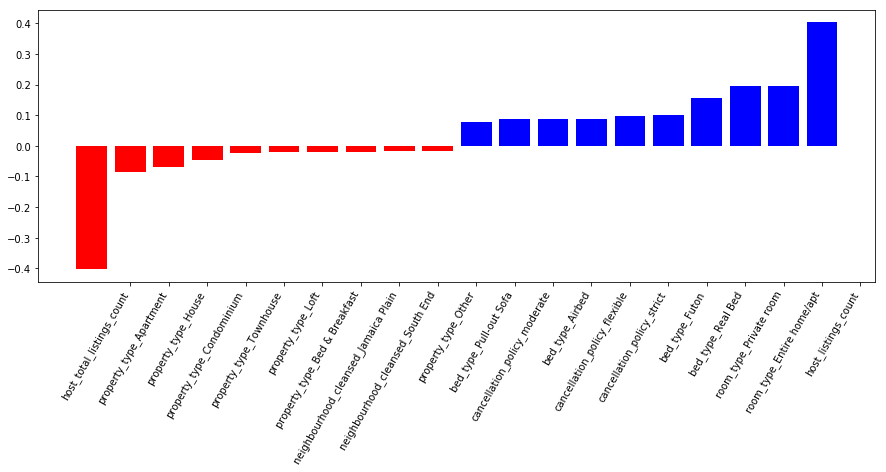

In [97]:
coef = lr.coef_.ravel()
coef /= abs(coef).sum()
coef = np.dot(coef.reshape(1,-1),pca.components_).reshape(-1,)
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(1, 1 + 2 * top_features), np.asarray(b_listings_features_cols)[top_coefficients], rotation=60, ha='right')
# plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()

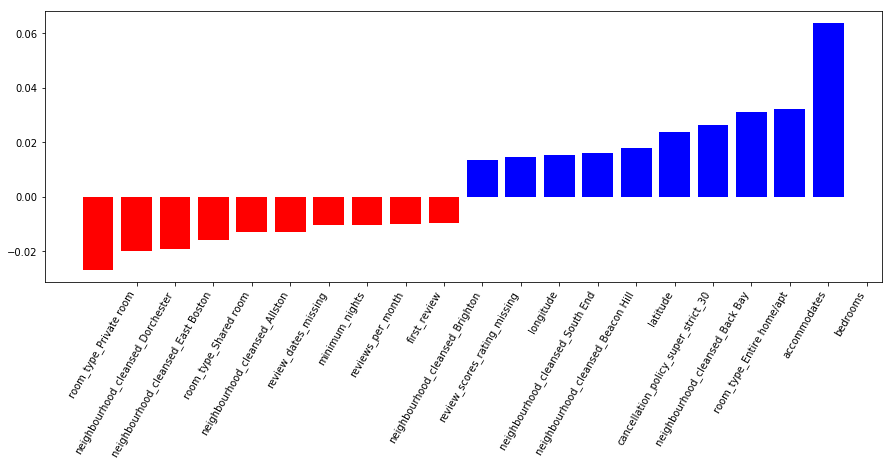

In [96]:
coef = svr.coef_.ravel()
coef /= abs(coef).sum()
coef = np.dot(coef.reshape(1,-1),pca.components_).reshape(-1,)
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(1, 1 + 2 * top_features), np.asarray(b_listings_features_cols)[top_coefficients], rotation=60, ha='right')
# plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()